# 資料預處理

In [178]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 二值化

將原圖轉為黑白

In [179]:
def binarize_image(img):
    """
    將灰階或 RGB 圖二值化 (Otsu)
    img: np.array (灰階或 RGB)
    回傳: binary (二值圖)
    """
    if len(img.shape) == 3:  # RGB → 灰階
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    
    return binary

## 腐蝕

In [180]:
def erode_image(binary_img, kernel_size=(3,1), iterations=1):
    """
    對二值圖做腐蝕
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    eroded = cv2.erode(binary_img, kernel, iterations=iterations)
    
    return eroded


Bounding box of white region

In [181]:
def crop_white_region(binary_img):
    """
    找出二值圖中白色區域的 bounding box 並裁切二值圖
    binary_img: Erosion 後的二值圖
    回傳:
        cropped_binary: 裁切後的二值圖
        bbox: (xmin, xmax, ymin, ymax)
    """
    ys, xs = np.where(binary_img == 255)
    if len(xs) > 0 and len(ys) > 0:
        xmin, xmax = xs.min(), xs.max()
        ymin, ymax = ys.min(), ys.max()
        cropped_binary = binary_img[ymin:ymax+1, xmin:xmax+1]
        # print(f"xmin={xmin}, xmax={xmax}, ymin={ymin}, ymax={ymax}")
        return cropped_binary, (xmin, xmax, ymin, ymax)
    else:
        print("沒有偵測到白色區域")
        return binary_img, (0, binary_img.shape[1], 0, binary_img.shape[0])


## 黏連字母自動定位與切分方法

此方法用於處理驗證碼中可能黏連的字母，主要流程如下：

1. **連通域定位**  
   將驗證碼圖片二值化，利用連通元件分析（Connected Components Analysis, CCA）找到每個白色像素相連的區域。每個區域可能是一個字，也可能是多個黏在一起的字。計算每個區域的中心（centroid）作為原始中心點。

2. **中心修正**  
   計算每個連通域中所有白色像素到中心的最大距離 `max_distance`，並設定基準距離 `k`。  
   - `max_distance <= 2k` → 單字  
   - `2k < max_distance <= 3k` → 兩字黏連  
   - `3k < max_distance <= 4k` → 三字黏連  
   對多字黏連的區域，水平均分生成新的中心點，作為估計的每個字中心。

3. **字母切分與 bounding box 生成**  
   根據每個估計中心點建立矩形邊界框（bounding box）：  
   - 單字母：使用原連通域邊界  
   - 多字黏連：水平範圍均分，矩形框左右各半寬  
   這些 bounding box 可以用於後續字母裁切或識別。

> 總結：此方法結合連通域分析與距離推估，能自動處理黏連字母並定位每個字的位置，適合驗證碼自動分割。


In [182]:
def k_based_segmentation_with_merge(binary_img, k=20, h_thresh_ratio=0.4):
    """
    binary_img: 裁切後二值圖
    k: 字母大小基準距離
    h_thresh_ratio: 小區塊高度閾值比，例如小於0.4倍最大高度視為小區塊
    回傳:
        all_boxes: 每個字母的 bounding box [(xmin, ymin, xmax, ymax)]
    """
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=8)

    boxes = []
    small_blocks = []

    # 先判斷高度閾值
    heights = stats[1:, cv2.CC_STAT_HEIGHT]  # 忽略背景
    if len(heights) == 0:
        return []
    h_thresh = h_thresh_ratio * heights.max()

    # 分組：小區塊與正常區塊
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if h < h_thresh:
            small_blocks.append((x, y, x+w, y+h))
        else:
            boxes.append([x, y, x+w, y+h])

    # 合併小區塊到最近的大區塊
    for sxmin, symin, sxmax, symax in small_blocks:
        # 計算水平距離最近的大區塊
        min_dist = float('inf')
        target_idx = -1
        for idx, (xmin, ymin, xmax, ymax) in enumerate(boxes):
            # 水平距離
            dist = abs((sxmin+sxmax)/2 - (xmin+xmax)/2)
            if dist < min_dist:
                min_dist = dist
                target_idx = idx
        if target_idx >= 0:
            # 合併成矩形區塊
            xmin, ymin, xmax, ymax = boxes[target_idx]
            new_xmin = min(xmin, sxmin)
            new_xmax = max(xmax, sxmax)
            new_ymin = min(ymin, symin)
            new_ymax = max(ymax, symax)
            boxes[target_idx] = [new_xmin, new_ymin, new_xmax, new_ymax]

    # 根據 k 值重新分割黏連字母
    all_boxes = []
    for xmin, ymin, xmax, ymax in boxes:
        width = xmax - xmin
        num_letters = max(1, int(np.ceil(width / k)))
        if num_letters == 1:
            all_boxes.append((xmin, ymin, xmax, ymax))
        else:
            new_centers_x = np.linspace(xmin, xmax, num_letters+2)[1:-1]
            for nx in new_centers_x:
                sub_xmin = int(nx - width/(2*num_letters))
                sub_xmax = int(nx + width/(2*num_letters))
                all_boxes.append((sub_xmin, ymin, sub_xmax, ymax))

    return all_boxes

In [183]:
def visualize_and_cut(cropped_img, char_boxes):
    """
    cropped_img: 二值化、腐蝕後，經過白色區域裁切的圖像 (numpy array)
    char_boxes: Cell4 返回的每個字 bounding box [(xmin, ymin, xmax, ymax)]
    回傳: char_imgs (每個字的裁切圖列表)
    """
    # 可視化
    img_vis = cv2.cvtColor(cropped_img, cv2.COLOR_GRAY2RGB)  # 轉成彩色方便畫框
    for (xmin, ymin, xmax, ymax) in char_boxes:
        cv2.rectangle(img_vis, (xmin, ymin), (xmax, ymax), (0,255,0), 1)


    # 裁切每個字符
    char_imgs = [cropped_img[ymin:ymax, xmin:xmax] for (xmin, ymin, xmax, ymax) in char_boxes]
    return char_imgs

加上出血

In [184]:
def add_padding(img, pad=2):
    """
    img: 二值圖 (numpy array)
    pad: 邊界出血大小 (像素)
    """
    h, w = img.shape
    padded = np.zeros((h+2*pad, w+2*pad), dtype=img.dtype)  # 黑色 padding
    padded[pad:pad+h, pad:pad+w] = img
    return padded

DEMO

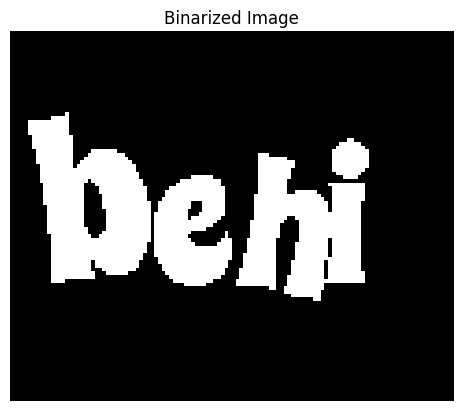

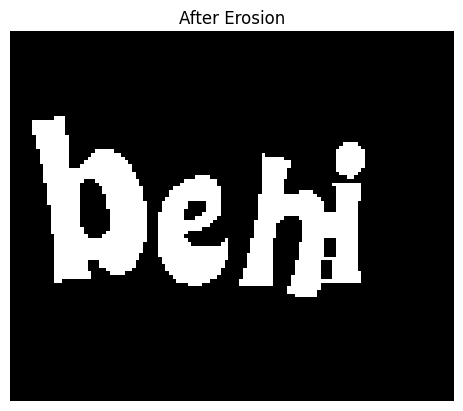

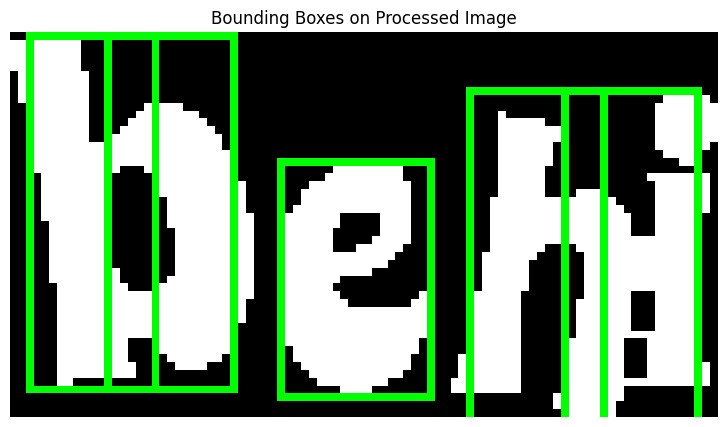

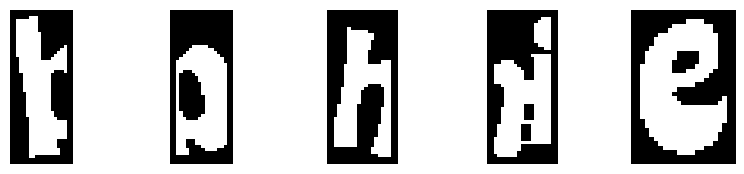

In [185]:
img = cv2.imread("captcha_raw/behi.png")

img_prcd = binarize_image(img)
plt.imshow(img_prcd, cmap='gray')
plt.title("Binarized Image")
plt.axis("off")
plt.show()

img_prcd = erode_image(img_prcd)
plt.title("After Erosion")
plt.imshow(img_prcd, cmap='gray')
plt.axis("off")
plt.show()

img_prcd, bbox_crop = crop_white_region(img_prcd)
char_boxes = k_based_segmentation_with_merge(img_prcd, k=22)

char_imgs = visualize_and_cut(img_prcd, char_boxes)

# 先可視化整張圖片與 bounding box
img_vis = cv2.cvtColor(img_prcd, cv2.COLOR_GRAY2RGB)
for (xmin, ymin, xmax, ymax) in char_boxes:
    cv2.rectangle(img_vis, (xmin, ymin), (xmax, ymax), (0,255,0), 1)

plt.figure(figsize=(12,5))
plt.title("Bounding Boxes on Processed Image")
plt.imshow(img_vis)
plt.axis("off")
plt.show()


# 對每個裁切出的字符加 padding
char_imgs_padded = [add_padding(char, pad=2) for char in char_imgs]

# 可視化加 padding 後的每個字符
num_chars = len(char_imgs_padded)
plt.figure(figsize=(num_chars*2, 2))
for i, char_img in enumerate(char_imgs_padded):
    plt.subplot(1, num_chars, i+1)
    plt.imshow(char_img, cmap='gray')
    plt.axis("off")
plt.show()

批次處理

In [186]:
import os
from tqdm import tqdm

def preprocess(raw_folder="captcha_raw", save_folder="captcha_slicey", k_init=22, pad=2, max_iter=5):
    os.makedirs(save_folder, exist_ok=True)
    
    img_files = [f for f in os.listdir(raw_folder) if f.lower().endswith(".png")]
    
    for img_name in tqdm(img_files, desc="Processing Captchas"):
        img_path = os.path.join(raw_folder, img_name)
        img = cv2.imread(img_path)
        
        # 流水線處理
        img_prcd = binarize_image(img)
        img_prcd = erode_image(img_prcd)
        img_prcd, _ = crop_white_region(img_prcd)
        
        # 自動調整 k 值
        k = k_init
        target_chars = len(os.path.splitext(img_name)[0])
        for _ in range(max_iter):
            char_boxes = k_based_segmentation_with_merge(img_prcd, k=k)
            if len(char_boxes) == target_chars:
                break
            elif len(char_boxes) > target_chars:
                k += 1
            else:
                k = max(1, k-1)
        
        if len(char_boxes) != target_chars:
            print(f"[WARNING] {img_name} -> expected {target_chars} chars, got {len(char_boxes)}, final k={k}")
            continue
        
        # 按 x 座標排序
        char_boxes_sorted = sorted(char_boxes, key=lambda x: x[0])
        
        # 切割並依字母儲存
        for idx, (xmin, ymin, xmax, ymax) in enumerate(char_boxes_sorted):
            char_img = img_prcd[ymin:ymax, xmin:xmax]
            char_img = add_padding(char_img, pad=pad)
            
            letter = os.path.splitext(img_name)[0][idx]  # 對應答案
            
            # 建立子資料夾 a-z
            letter_folder = os.path.join(save_folder, letter)
            os.makedirs(letter_folder, exist_ok=True)
            
            save_name = f"{os.path.splitext(img_name)[0]}_{letter}.png"
            save_path = os.path.join(letter_folder, save_name)
            
            cv2.imwrite(save_path, char_img)



In [188]:
preprocess(raw_folder="captcha_raw", save_folder="captcha_slice", k_init=20, pad=2, max_iter=50)


Processing Captchas:   9%|▊         | 40/467 [00:00<00:02, 198.18it/s]

[WARNING] cdia.png -> expected 4 chars, got 5, final k=28


Processing Captchas:  68%|██████▊   | 318/467 [00:01<00:00, 206.83it/s]

[WARNING] qoho.png -> expected 4 chars, got 5, final k=32


Processing Captchas: 100%|██████████| 467/467 [00:02<00:00, 207.67it/s]
